## Linear interpolation along yz plane

Here, we determine the neighbours in the deskewed image in the yz plane. 

Neighbours of coordinate xyz are:
* bottom left (y+1,z-1) -> yz1
* top left (y-1,z-1)  -> yz2
* top right (y-1,z+1)  -> yz3
* top left (y+1,z+1)  -> yz4

Once we get the neighbours, we apply an inverse deskew transform to find corresponding pixel values in the raw data. We then interpolate between these coordinates


(209, 118, 209)
(59, 1832, 209)
Current interpolation yields:


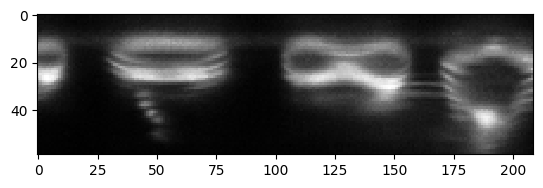

In [1]:
import math
import pyclesperanto_prototype as cle
from pyclesperanto_prototype._tier8._affine_transform import _determine_translation_and_bounding_box
from skimage.io import imread
import numpy as np 
#Disable scientific notation for numbers
np.set_printoptions(suppress=True)

voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30

original_image = imread("../../data/RBC_tiny.tif")

original_image = original_image[::4]
voxel_size_z_in_microns = voxel_size_z_in_microns * 4
print(original_image.shape)


#Defining Deskewing transform 

scale_factor = 1 #Scale factor is used in clesperanto if we want to scale the images in case they don't fit in memory

#initialise a transform
deskew_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
deskew_transform._matrix[1, 2] = shear_factor
#Scale
new_dz = math.sin(deskewing_angle_in_degrees * math.pi / 180.0) * voxel_size_z_in_microns
scale_factor_z = (new_dz / voxel_size_y_in_microns) * scale_factor
deskew_transform.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
#Rotate deskewing angle
deskew_transform.rotate(angle_in_degrees = 0 - deskewing_angle_in_degrees, axis=0)
_,deskew_transform,translation = _determine_translation_and_bounding_box(original_image, deskew_transform)

deskew_transform._matrix
deskewed = cle.affine_transform(source= original_image,transform = deskew_transform,auto_size=True,linear_interpolation=True)
deskewed = cle.pull(deskewed)
print(deskewed.shape)

print("Current interpolation yields:")
cle.imshow(deskewed[:,200])

In [2]:
#Get shear transform
shear_transform =cle.AffineTransform3D()
#Shear
shear_factor = math.sin((90 - deskewing_angle_in_degrees) * math.pi / 180.0) * (voxel_size_z_in_microns/voxel_size_y_in_microns)
shear_transform._matrix[1, 2] = shear_factor

#Inverse shear transform
shear_inverse = shear_transform.copy().inverse()


##rotation,scaling and translation
#second step of the deskewing workflow
rot_trans = cle.AffineTransform3D()
#Scale
new_dz = math.sin(deskewing_angle_in_degrees * math.pi / 180.0) * voxel_size_z_in_microns
scale_factor_z = (new_dz / voxel_size_y_in_microns) * scale_factor
rot_trans.scale(scale_x=scale_factor, scale_y=scale_factor, scale_z=scale_factor_z)
#Rotate deskewing angle
rot_trans.rotate(angle_in_degrees = 0 - deskewing_angle_in_degrees, axis=0)
rot_trans.translate(translation[0],translation[1],translation[2])

#inverse rotate translate matrix
rot_trans_inv = rot_trans.copy().inverse()

#inverse deskew
deskew_inverse = deskew_transform.copy().inverse()


In [3]:
#Bilinear interpolation

#Lets say we want to find neighbours for coordinate in deskewed image (xyz): 70, 464, 21
#
coord = [70,464,21,1]
print("Deskewed image coordinates are:", coord)

#Apply inverse deskew to find corresponding coordinaes in original image
deskew_inv_coord = deskew_inverse._matrix@coord
print("On raw image, coordinates are:", deskew_inv_coord)

#Apply shear transform to find coordinates in sheared image
sheared_img_coord_rev = rot_trans_inv._matrix@coord
print("On intermediate sheared image, reverse rot trans gives coordinates:", sheared_img_coord_rev)

#Apply shear transform to find coordinates in sheared image
sheared_img_coord = shear_transform._matrix@deskew_inv_coord
print("On intermediate sheared image, inverse shear gives coordinates:", sheared_img_coord)

Deskewed image coordinates are: [70, 464, 21, 1]
On raw image, coordinates are: [70.         76.         48.11107853  1.        ]
On intermediate sheared image, reverse rot trans gives coordinates: [ 70.         420.83578736  48.11107853   1.        ]
On intermediate sheared image, inverse shear gives coordinates: [ 70.         420.83578736  48.11107853   1.        ]


### Lets test the approach on the coordinate defined above to see what the neighbour coordinates will look like

In [41]:
#rotate_mat = rotate_around_cooord_mat(coord,angle_in_degrees=30)


#Find neighbours in the yz plane for the sheared image
transform_yz1_neighbour= cle.AffineTransform3D()
transform_yz2_neighbour= cle.AffineTransform3D()
transform_yz3_neighbour= cle.AffineTransform3D()
transform_yz4_neighbour= cle.AffineTransform3D()

#Distance between neighbours in xyz

#THIS MAY NEED ADJUSTING/RECALCULATION
z_step = 1
y_step = 1

#neighbours as defined in yz plane
transform_yz1_neighbour.translate(translate_y= y_step,translate_z= -z_step)

transform_yz2_neighbour.translate(translate_y= -y_step,translate_z=-z_step)

transform_yz3_neighbour.translate(translate_y= -y_step, translate_z= z_step)

transform_yz4_neighbour.translate(translate_y= y_step, translate_z=z_step)

#make intercept

yz1_deskew_neighbour = transform_yz1_neighbour._matrix@coord 
yz2_deskew_neighbour  = transform_yz2_neighbour._matrix@coord
yz3_deskew_neighbour = transform_yz3_neighbour._matrix@coord
yz4_deskew_neighbour = transform_yz4_neighbour._matrix@coord



print("Sheared inverse coord", sheared_img_coord)

print("Neighbour in deskew (orthogonal neighbours)")
print("orth_before", yz1_deskew_neighbour)
print("orth after",yz2_deskew_neighbour)
print("nearest_before", yz3_deskew_neighbour)
print("nearest after",yz4_deskew_neighbour)


yz1_neighbour = deskew_inverse._matrix@yz1_deskew_neighbour
yz2_neighbour = deskew_inverse._matrix@yz2_deskew_neighbour
yz3_neighbour = deskew_inverse._matrix@yz3_deskew_neighbour
yz4_neighbour = deskew_inverse._matrix@yz4_deskew_neighbour


print("Actual neighbours in the raw image")

print("1", yz1_neighbour)
print("2",yz2_neighbour)
print("3",yz3_neighbour)
print("4",yz4_neighbour)

Sheared inverse coord [ 70.         420.83578736  48.11107853   1.        ]
Neighbour in deskew (orthogonal neighbours)
orth_before [ 70. 465.  20.   1.]
orth after [ 70. 463.  20.   1.]
nearest_before [ 70. 463.  22.   1.]
nearest after [ 70. 465.  22.   1.]
Actual neighbours in the raw image
1 [70.         78.         48.02262714  1.        ]
2 [70.         78.         47.78097348  1.        ]
3 [70.         74.         48.19952991  1.        ]
4 [70.         74.         48.44118357  1.        ]


Now, lets try it using the corresponding functions. 

We use the translation transforms we defined above to find the neighbours

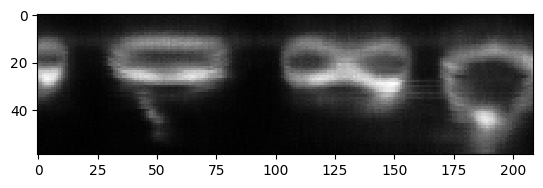

In [42]:
deskewed_test = cle.affine_transform_linear(source=original_image,
                                              transform= deskew_transform,
                                              transform_1=transform_yz1_neighbour,
                                              transform_2=transform_yz2_neighbour,
                                              transform_3=transform_yz3_neighbour,
                                              transform_4=transform_yz4_neighbour,
                                              voxel_size_y = voxel_size_y_in_microns,
                                              voxel_size_z=voxel_size_z_in_microns,
                                              auto_size=True)
cle.imshow(deskewed_test[:,200])

Edges are still a bit blurry. Its not that clear.
Step size issue??